In [1]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [2]:
import os
import time
import random
import torch
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import plot, ion, show, savefig, cla, figure
from pathlib import Path

from data_loader_pytorch import DataGenerator
from models_pytorch import VAEmodel, LSTMModel
from trainers_pytorch import VAETrainer
from utils import process_config, create_dirs

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # keep GPU ordering consistent
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [4]:
# load VAE model
config = process_config('config.json')
# create the experiments dirs
create_dirs([config['result_dir'], config['checkpoint_dir'], config['checkpoint_dir_lstm']])
# create your data generator
data = DataGenerator(config)

In [5]:
# create a VAE model and load the latest checkpoint
vae_model = VAEmodel(config).to(device)
vae_model.eval()
vae_trainer = VAETrainer(vae_model, data, config)

checkpoint_dir = config['checkpoint_dir']
checkpoint_files = [f for f in Path(checkpoint_dir).iterdir() if f.name.startswith('vae_checkpoint') and f.name.endswith('.pth')]
if not checkpoint_files:
    raise FileNotFoundError(f"No VAE checkpoint found in {checkpoint_dir}")
latest_checkpoint = max(checkpoint_files, key=lambda x: int(x.name.split('_')[-1].split('.')[0]))
vae_trainer.load_model(latest_checkpoint)
vae_model.eval()


Model loaded from ../experiments/local-results/WESAD/batch-32/WESAD-48-12-6-fixedSigma-0.1/checkpoint/vae_checkpoint_epoch_10.pth


VAEmodel(
  (enc_conv1): Conv2d(14, 32, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0))
  (enc_conv2): Conv2d(32, 64, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0))
  (enc_conv3): Conv2d(64, 128, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0))
  (enc_conv4): Conv2d(128, 512, kernel_size=(6, 1), stride=(1, 1))
  (enc_fc): Linear(in_features=512, out_features=24, bias=True)
  (enc_fc_mean): Linear(in_features=24, out_features=6, bias=True)
  (enc_fc_std): Linear(in_features=24, out_features=6, bias=True)
  (dec_fc): Linear(in_features=6, out_features=512, bias=True)
  (dec_conv1): Conv2d(512, 768, kernel_size=(1, 1), stride=(1, 1))
  (dec_conv2): Conv2d(256, 256, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (dec_conv3): Conv2d(128, 128, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (dec_conv4): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (dec_out): Conv2d(16, 14, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
)

In [6]:
# load LSTM model
lstm_model = LSTMModel(config).to(device)
lstm_checkpoint_path = Path(config['checkpoint_dir_lstm']) / 'lstm_model.pth'
if not lstm_checkpoint_path.is_file():
    raise FileNotFoundError(f"Expected LSTM checkpoint at {lstm_checkpoint_path}")
lstm_state_dict = torch.load(lstm_checkpoint_path, map_location=device)
lstm_model.load_state_dict(lstm_state_dict)
lstm_model.eval()
print(f"Loaded LSTM checkpoint: {lstm_checkpoint_path.name}")

Loaded LSTM checkpoint: lstm_model.pth


In [7]:
# load normalised time series
data_dir = Path('../data/')
filename = data_dir / 'test.csv'
df = pd.read_csv(filename)

result = {}
result['test'] = df.drop(columns=['label', 'subject_id'], axis=1).to_numpy()
result['idx_anomaly_test'] = df['label'].to_numpy()

# slice into rolling windows and rolling sequences
def slice_rolling_windows_and_sequences(config, time_seq):
    n_sample = len(time_seq)
    print("The given sequence has {} samples".format(n_sample))
    n_vae_win = n_sample - config['l_win'] + 1
    rolling_windows = np.zeros((n_vae_win, config['l_win'], time_seq.shape[1]), dtype=np.float32)
    for i in range(n_vae_win):
        rolling_windows[i] = time_seq[i:i + config['l_win']]

    n_lstm_seq = n_sample - config['l_seq']*config['l_win']+1
    lstm_seq = np.zeros((n_lstm_seq, config['l_seq'], config['l_win'], time_seq.shape[1]), dtype=np.float32)
    for i in range(n_lstm_seq):
        cur_seq = time_seq[i:i+config['l_seq']*config['l_win']]
        for j in range(config['l_seq']):
            lstm_seq[i,j] = cur_seq[config['l_win']*j:config['l_win']*(j+1)]

    return rolling_windows, lstm_seq

test_windows, test_seq = slice_rolling_windows_and_sequences(config, result['test'])
print(test_windows.shape)
print(test_seq.shape)


The given sequence has 17988 samples
(17941, 48, 14)
(17413, 12, 48, 14)


In [8]:
# Evaluate ELBO and LSTM prediction error on the validation set
# evaluate some anomaly detection metrics
def evaluate_vae_anomaly_metrics_for_a_window(test_win):
    window_tensor = torch.from_numpy(test_win).float().unsqueeze(0).to(device)
    with torch.no_grad():
        recon_win, latent_mean, latent_std = vae_model(window_tensor)
    recon_win = recon_win.squeeze(0).cpu().numpy()
    latent_mean = latent_mean.squeeze(0).cpu().numpy()
    latent_std = latent_std.squeeze(0).cpu().numpy()

    test_vae_recons_error = np.sum(np.square(recon_win - test_win))
    safe_std = np.clip(latent_std, 1e-9, None)
    test_vae_kl = 0.5 * (
        np.sum(np.square(latent_mean))
        + np.sum(np.square(safe_std))
        - np.sum(np.log(np.square(safe_std)))
        - config['code_size']
    )

    sigma2 = vae_model.get_sigma2().item()
    input_dims = vae_model.input_dims
    sigma_regularisor = input_dims / 2.0 * np.log(sigma2) + input_dims * np.pi
    test_vae_elbo = test_vae_recons_error / sigma2 + test_vae_kl + sigma_regularisor
    return test_vae_recons_error, test_vae_kl, test_vae_elbo


def evaluate_lstm_anomaly_metric_for_a_seq(test_seq):
    seq_tensor = torch.from_numpy(test_seq).float().to(device)
    seq_tensor = seq_tensor.view(config['l_seq'], config['l_win'], config['n_channel'])

    with torch.no_grad():
        vae_mean, _ = vae_model.encode(seq_tensor)
        input_embeddings = vae_mean[:-1].unsqueeze(0)
        lstm_pred = lstm_model(input_embeddings).squeeze(0)
        embedding_error = torch.sum((vae_mean[1:] - lstm_pred) ** 2).item()

        reconstructed = vae_model.decode(lstm_pred)
        reconstructed = reconstructed.squeeze(-1)
        target_windows = seq_tensor[1:].squeeze(-1)
        reconstruction_error = torch.sum((reconstructed - target_windows) ** 2).item()

    return reconstruction_error, embedding_error

n_val_vae = data.val_set_vae['data'].shape[0]
n_val_lstm = data.val_set_lstm['data'].shape[0]

val_vae_recons_error = np.zeros(n_val_vae)
val_vae_kl_error = np.zeros(n_val_vae)
val_vae_elbo_loss = np.zeros(n_val_vae)
for i in range(n_val_vae):
    val_vae_recons_error[i], val_vae_kl_error[i], val_vae_elbo_loss[i] = evaluate_vae_anomaly_metrics_for_a_window(data.val_set_vae['data'][i])

val_lstm_recons_error, val_lstm_embedding_error = np.zeros(n_val_lstm), np.zeros(n_val_lstm)
for i in range(n_val_lstm):
    val_lstm_recons_error[i], val_lstm_embedding_error[i] = evaluate_lstm_anomaly_metric_for_a_seq(data.val_set_lstm['data'][i])


In [9]:
from scipy.stats import norm
def plot_histogram(test_anomaly_metric, n_bins, title, mean=None, std=None, xlim=None, saveplot=False):
    test_anomaly_list = np.squeeze(np.ndarray.flatten(test_anomaly_metric))
    his = plt.hist(test_anomaly_list, bins=n_bins, density=True)
    if mean is None and std is None:
        mean = np.mean(test_anomaly_list)
        std = np.std(test_anomaly_list)
        legend_label = None
    else:
        legend_label = 1
    x_axis = np.arange(mean-5*std, mean+5*std, std/100)
    plt.plot(x_axis, norm.pdf(x_axis,mean,std))
    plt.title(title)
    plt.xlabel('anomaly score value')
    plt.ylabel('probability density')
    if xlim is not None:
        plt.xlim(0, xlim)
    else:
        plt.xlim(0, np.amax(test_anomaly_list))
    if legend_label is None:
        plt.legend(('Fitted Gaussian', 'histogram'))
    else:
        plt.legend(('normal data distribution','test data distribution (contain anomalies)'))
    if saveplot:
        savefig(config['result_dir']+'reconstruction_error_histogram.pdf')
    else:
        plt.show()
    threshold_25 = np.percentile(test_anomaly_list, 25)
    threshold_75 = np.percentile(test_anomaly_list, 75)
    threshold_1 = np.percentile(test_anomaly_list, 99)
    idx_large_error = np.squeeze(np.argwhere(test_anomaly_metric > threshold_1))
#     print(his[0][-20:])
#     print(his[1][-20:])
    print("25% percentile: {}".format(threshold_25))
    print("75% percentile: {}".format(threshold_75))
#     print("Median: {}".format(np.median(test_anomaly_list)))
#     print("Mean: {}".format(np.mean(test_anomaly_list)))
#     print("Std dev: {}".format(np.std(test_anomaly_list)))
    print("These windows scored the top 1% of anomaly metric ({}): \n{}".format(threshold_1, idx_large_error))
    return mean, std

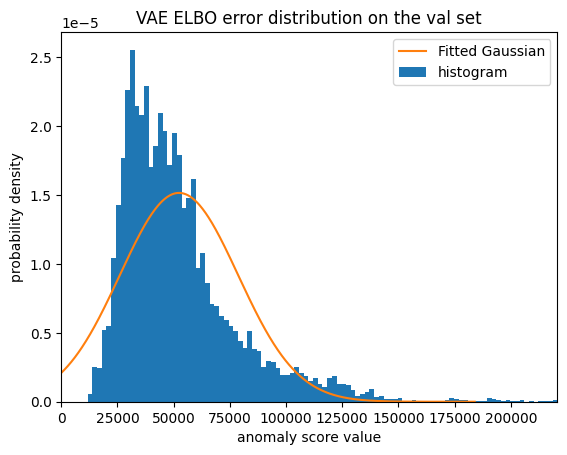

25% percentile: 33844.39176410046
75% percentile: 62178.081488975695
These windows scored the top 1% of anomaly metric (137818.56447294974): 
[ 6075  6076  6077  6078  6079  6080  6081  6082  6083  6084  6085  6086
  6087  6088  6089  6090  6091  6092  6093  6094  6095  6096  6097  6098
  6099  6100  6101  6102  6103  6104  6105  6106  6107  6108  6109  6110
  6111  6112  6113  6114  6115  6116  6117  6118  6119  6120  6121  6122
  6739  6742  6743  6744  6745  6746  6747  6748  6749  6750  6751  6752
  6753  6754  6755 15203 15204 15205 15206 15207 15208 15209 15210 15211
 15212 15213 15214 15215 15216 15282 15284 15285 15286 15287 15288 15289
 15290 15291 15292 15293 15294 15295 15300 15301 15302 15970 15971 15972
 15973 15974 15975 15976 15980 15983 15984 15989 15990 15991 16000 16001
 16002 16003 16004 16005 16006 16007 16008 16009 16010 16011 16012 16013
 16014 16015 16016 16024 16028 16029 16035 16036 16037 16038 16039 16040
 16041 16042 16043 16044 16045 16046 16047 16048 16049 

In [10]:
# Histogram of VAE ELBO loss - validation set
vae_elbo_m, vae_elbo_std = plot_histogram(val_vae_elbo_loss, 100, 
                                          'VAE ELBO error distribution on the val set', 
                                          mean=None, std=None, xlim=None)

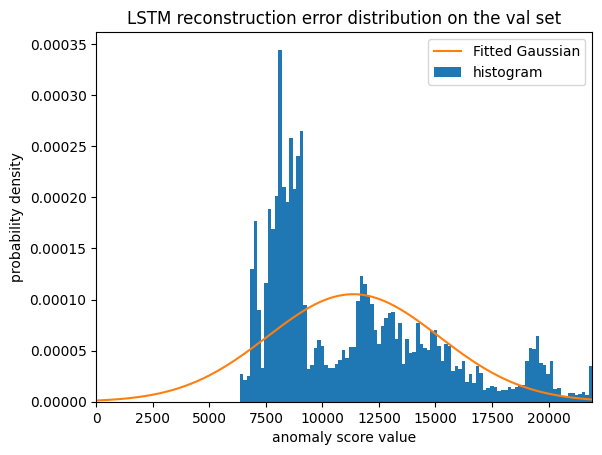

25% percentile: 8250.6435546875
75% percentile: 13766.013671875
These windows scored the top 1% of anomaly metric (21198.337968750002): 
[  233   234   235   236   593   594   595   596   953   954   955   956
  1313  1314  1315  1316  1673  1674  1675  1676  2033  2034  2035  2036
  2393  2394  2395  2396  2753  2754  2755  2756  3113  3114  3115  3473
  3474  3475  3833  3834  3835  4193  4194  4195  4553  4554  4555  4913
  4914  4915  5273  5274  5275  5633  5634  5635  5993  5994  5995  6353
  6354  6355  6713  6714  6715  7073  7074  7075  7433  7434  7435  7793
  7794  7795  8153  8154  8155  8513  8514  8515  8873  8874  8875  9233
  9234  9235  9593  9594  9595  9952  9953  9954  9955 10312 10313 10314
 10315 10672 10673 10674 10675 11032 11033 11034 11035 11392 11393 11394
 11395 11752 11753 11754 11755 12112 12113 12114 12115 12471 12472 12473
 12474 12830 12831 12832 12833 13189 13190 13191 13192 13548 13549 13550
 13551 13907 13908 13909 13910 14266 14267 14268 14269 14625

In [11]:
# Histogram of LSTM reconstruction error - validation set 
#  --> to decide the anomaly detection threshold
lstm_recons_m, lstm_recons_std = plot_histogram(val_lstm_recons_error, 100,  
                                              'LSTM reconstruction error distribution on the val set', 
                                              mean=None, std=None, xlim=None)

In [12]:
# Evaluate the anomaly metrics on the test windows and sequences
n_test_lstm = test_seq.shape[0]

test_lstm_recons_error, test_lstm_embedding_error = np.zeros(n_test_lstm), np.zeros(n_test_lstm)
for i in range(n_test_lstm):
    test_lstm_recons_error[i], test_lstm_embedding_error[i] = evaluate_lstm_anomaly_metric_for_a_seq(test_seq[i])
print("All windows' reconstruction error is computed.")
print("The total number of windows is {}".format(len(test_lstm_recons_error)))

All windows' reconstruction error is computed.
The total number of windows is 17413


25% percentile: 3451371.25
75% percentile: 4342511.5
These windows scored the top 1% of anomaly metric (6044934.5200000005): 
[15350 15351 15352 15353 15354 15355 15356 15357 15358 15359 15360 15361
 15362 15363 15364 15365 15366 15367 15368 15369 15370 15371 15372 15373
 15374 15375 15376 15377 15378 15379 15380 15381 15382 15383 15384 15385
 15386 15387 15388 15389 15390 15391 15392 15393 15394 15395 15396 15397
 15398 15399 15400 15401 15402 15403 15404 15405 15406 15407 15408 15409
 15410 15411 15412 15413 15414 15415 15416 15417 15418 15419 15420 15421
 15422 15423 15424 15425 15426 15427 15428 15429 15430 15431 15432 15433
 15434 15435 15436 15437 15438 15439 15440 15441 15442 15443 15444 15445
 15446 15447 15448 15449 15450 15451 15452 15453 15454 15455 15456 15457
 15458 15459 15460 15461 15462 15463 15464 15465 15466 15467 15468 15469
 15470 15471 15472 15473 15474 15475 15476 15477 15478 15479 15480 15481
 15482 15483 15484 15485 15486 15487 15488 15489 15490 15491 15492 1549

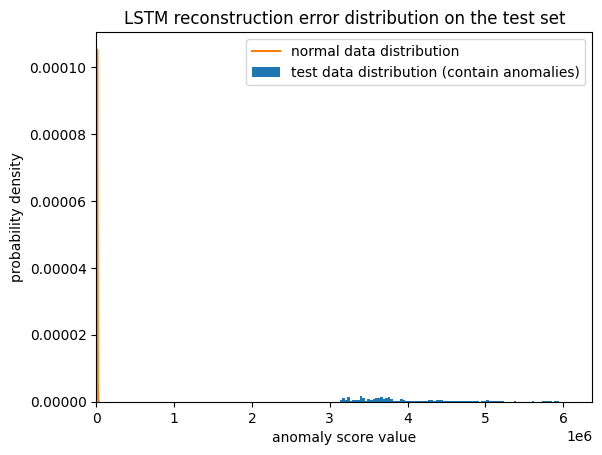

In [13]:
# Histogram of LSTM reconstruction error - test set 
#  --> to detect anomaly now
_, _ = plot_histogram(test_lstm_recons_error, 100,
                      'LSTM reconstruction error distribution on the test set', 
                      mean=lstm_recons_m, std=lstm_recons_std, xlim=None, saveplot=True)

In [14]:
# Produce the ground truth anomaly indices 
# if result['idx_split'][0] == 0:
#     idx_anomaly_test = result['idx_anomaly_test']
# else:
#     idx_anomaly_test = result['idx_anomaly_test'][0]
idx_anomaly_test = result['idx_anomaly_test']    
anomaly_index_lstm = []
test_labels_lstm = np.zeros(n_test_lstm)
for i in range(len(idx_anomaly_test)):
    idx_start = idx_anomaly_test[i]-(config['l_win']*config['l_seq']-1)
    idx_end = idx_anomaly_test[i]+1
    if idx_start < 0:
        idx_start = 0
    if idx_end > n_test_lstm:
        idx_end = n_test_lstm
    anomaly_index_lstm.append(np.arange(idx_start,idx_end))
    test_labels_lstm[idx_start:idx_end] = 1
    
print(test_labels_lstm.shape)

(17413,)


In [15]:
def return_anomaly_idx_by_threshold(test_anomaly_metric, threshold):
    test_list = np.squeeze(np.ndarray.flatten(test_anomaly_metric))
    idx_error = np.squeeze(np.argwhere(test_anomaly_metric > threshold))
    
    if len(idx_error.shape) == 0:
        idx_error = np.expand_dims(idx_error, 0)
    
    return list(idx_error)

In [16]:
def augment_detected_idx(idx_detected_anomaly, anomaly_index):
    n_anomaly = len(anomaly_index)
    idx_detected_anomaly_extended = list(idx_detected_anomaly)
    for i in range(n_anomaly):
        #print(idx_detected_anomaly)
        for j in idx_detected_anomaly:
            if j in anomaly_index[i]:
                in_original_detection = set(idx_detected_anomaly_extended)
                currect_anomaly_win = set(anomaly_index[i])
                idx_detected_anomaly_extended = idx_detected_anomaly_extended + list(currect_anomaly_win - in_original_detection)
                #print(j)
                break
                
    return list(np.sort(idx_detected_anomaly_extended))

In [17]:
def count_TP_FP_FN(idx_detected_anomaly, anomaly_index, test_labels):
    n_TP = 0
    n_FP = 0
    n_detection = len(idx_detected_anomaly)
    for i in range(n_detection):
        if test_labels[idx_detected_anomaly[i]] == 1:
            n_TP = n_TP + 1
        else:
            n_FP = n_FP + 1
    
    idx_undetected = list(set(np.arange(len(test_labels)))- set(idx_detected_anomaly))
    n_FN = 0
    for i in idx_undetected:
        if test_labels[i] == 1:
            n_FN = n_FN + 1
    
    return n_TP, n_FP, n_FN

In [18]:
def compute_precision_and_recall(idx_detected_anomaly, anomaly_index, test_labels):
    # compute true positive
    n_TP, n_FP, n_FN = count_TP_FP_FN(idx_detected_anomaly, anomaly_index, test_labels)
    
    if n_TP + n_FP == 0:
        precision = 1
    else:
        precision = n_TP / (n_TP + n_FP)
    recall = n_TP / (n_TP + n_FN)
    if precision + recall == 0:
        F1 = 0
    else:
        F1 = 2* (precision * recall)/(precision + recall)
    
    return precision, recall, F1, n_TP, n_FP, n_FN

In [19]:
n_threshold = 200
precision = np.zeros(n_threshold)
recall = np.zeros(n_threshold)
F1 = np.zeros(n_threshold)
precision_aug = np.zeros(n_threshold)
recall_aug = np.zeros(n_threshold)
F1_aug = np.zeros(n_threshold)
i = 0
threshold_list = np.linspace(np.amin(test_lstm_recons_error), np.amax(test_lstm_recons_error), n_threshold, endpoint=True)
threshold_list = np.flip(threshold_list)
for threshold in threshold_list:
    #print(threshold_list[i])
    idx_detection_lstm = return_anomaly_idx_by_threshold(test_lstm_recons_error, threshold)
    precision[i], recall[i], F1[i], _, _, _ = compute_precision_and_recall(idx_detection_lstm, 
                                                                           anomaly_index_lstm, 
                                                                           test_labels_lstm)
    # augment the detection using the ground truth labels
    # a method to discount the factor one anomaly appears in multiple consecutive windows
    # introduced in "Unsupervised anomaly detection via variational auto-encoder for seasonal kpis in web applications"
    idx_detection_lstm_augmented = augment_detected_idx(idx_detection_lstm, anomaly_index_lstm)
    precision_aug[i], recall_aug[i], F1_aug[i], _, _, _ = compute_precision_and_recall(idx_detection_lstm_augmented, 
                                                                                       anomaly_index_lstm, 
                                                                                       test_labels_lstm)
    i = i + 1
    #print(precision, recall, F1)

KeyboardInterrupt: 

In [ ]:
print("Best F1 score is {}".format(np.amax(F1)))
idx_best_threshold = np.squeeze(np.argwhere(F1 == np.amax(F1)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
print("At this threshold, precision is {}, recall is {}".format(precision[idx_best_threshold], recall[idx_best_threshold]))
average_precision = np.sum(precision[1:] * (recall[1:] - recall[:-1]))
print("Average precision is {}".format(average_precision))

print("\nAugmented detection:")
print("Best F1 score is {}".format(np.amax(F1_aug)))
idx_best_threshold = np.squeeze(np.argwhere(F1_aug == np.amax(F1_aug)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
print("At this threshold, precision is {}, recall is {}".format(precision_aug[idx_best_threshold], 
                                                                recall_aug[idx_best_threshold]))

average_precision_aug = np.sum(precision_aug[1:] * (recall_aug[1:] - recall_aug[:-1]))
print("Average precision is {}".format(average_precision_aug))

In [ ]:
# Now select a threshold
threshold = 4399

print("Threshold is {}".format(threshold))
idx_detection = return_anomaly_idx_by_threshold(test_lstm_recons_error, threshold)
idx_detection_augmented = augment_detected_idx(idx_detection, anomaly_index_lstm)
precision, recall, F1, n_TP, n_FP, n_FN = compute_precision_and_recall(idx_detection_augmented, 
                                                                       anomaly_index_lstm, 
                                                                       test_labels_lstm)
print("\nPR evaluation using augmented detection:")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(F1))
print("TP: {}".format(n_TP))
print("FP: {}".format(n_FP))
print("FN: {}".format(n_FN))

In [ ]:
def slice_detected_indices_into_seq(idx_detection, interval):
    detected_seq = []
    i = 0
    while i < len(idx_detection):
        if i == 0:
            cur_seq = [idx_detection[i]]
            i = i + 1
        else:
            if idx_detection[i] - idx_detection[i-1] > interval:
                detected_seq.append(cur_seq)
                cur_seq = [idx_detection[i]]
            else:
                cur_seq.append(idx_detection[i])
                if i == len(idx_detection) - 1:
                    detected_seq.append(cur_seq)
            i = i + 1
    
    print("Detected {} sequences".format(len(detected_seq)))
    return detected_seq

In [ ]:
def plot_detected_anomalies(idx_detection, interval, dataset, result, detection_method, augmented_flag=1, y_scale=5, y_lim=None):
    detected_seq = slice_detected_indices_into_seq(idx_detection, interval=interval)
    t_test = result['t_test']
    test = result['test']
    idx_anomaly_test = result['idx_anomaly_test']
        
    # plot detected sequences
    fig, axs = plt.subplots(1, 1, figsize=(18, 5), edgecolor='k')
    fig.subplots_adjust(hspace=.4, wspace=.4)
    axs.plot(t_test, test)
    for j in range(len(idx_anomaly_test)):
        if j == 0:
            axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r--', label='true anomalies')
        else:
            axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r--')
        
    for i in range(len(detected_seq)):
        for j in detected_seq[i]:
            if j == detected_seq[0][0]:
                axs.plot((j+interval*2) * np.ones(20), np.linspace(-y_scale, -0.8*y_scale, 20), 'g-', label='detected anomalies')
            else:
                axs.plot((j+interval*2) * np.ones(20), np.linspace(-y_scale, -0.8*y_scale, 20), 'g-')
    
    for j in range(len(idx_anomaly_test)):
        axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r--')

    for i in range(len(detected_seq)):
        interval_x = np.asarray([detected_seq[i][0], detected_seq[i][-1]+interval*2])
        interval_y = np.asarray([y_scale,y_scale])
        if i == 0:
            axs.fill_between(interval_x, interval_y, alpha=0.2, color='y', label='detected anomaly windows')
        else:
            axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
        interval_y = np.asarray([-y_scale,-y_scale])
        axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
    axs.grid(True)
    axs.set_xlim(0, len(t_test))
    if y_lim is None:
        axs.set_ylim(-y_scale, y_scale)
    else:
        axs.set_ylim(-y_scale, y_lim)
    axs.set_xlabel("timestamp (every {})".format(result['t_unit']))
    axs.set_ylabel("normalised readings")
    axs.set_title("{} dataset test sequence\n(normalised by train mean {:.4f} and std {:.4f})\n Detection method: {}".format(dataset, 
                                                                                        result['train_m'], 
                                                                                        result['train_std'],
                                                                                        detection_method))
    axs.legend()
    savefig(config['result_dir']+'detected_anomalies_{}_aug_{}.pdf'.format(detection_method, augmented_flag))

In [ ]:
plot_detected_anomalies(idx_detection_augmented, 
                        interval=config['l_win']*config['l_seq']/2, 
                        dataset=dataset, 
                        result=result, 
                        detection_method='lstm reconstruction error',
                        augmented_flag=1,
                        y_scale=5,
                        y_lim=5)